> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on GitHub
> - ▶️ Demo: [try this model in action](https://trekhleb.github.io/machine-learning-experiments)

Inspired by [Learn to Add Numbers with an Encoder-Decoder LSTM Recurrent Neural Network](https://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/) article.

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [3]:
dataset_size = 1000
sequence_length = 2
max_num = 100

In [4]:
def generate_sums(dataset_size, sequence_length, max_num):
    # Initial dataset states.
    x, y = [], []
    
    # Generating sums.
    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [5]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:3])
print()
print('y_train:\n', y_train[:3])

x_train:
 [[84, 38], [5, 20], [81, 36]]

y_train:
 [122, 25, 117]


In [6]:
def dataset_to_strings(x, y, max_num):
    # Initial dataset states.
    x_str, y_str = [], []
    
    sequnce_length = len(x[0])
    
    # Calculate the maximum length of equation (x) string (i.e. of "11+99")
    num_of_pluses = sequnce_length - 1
    num_of_chars_per_digit = math.ceil(math.log10(max_num + 1))
    max_x_length = sequnce_length * num_of_chars_per_digit + num_of_pluses
    
    # Calculate the maximum length of label (y) string (i.e. of "167")
    max_y_length = math.ceil(math.log10(sequnce_length * (max_num + 1)))
    
    # Add a space " " padding to equation strings to make them of the same length.
    for example in x:
        str_example = '+'.join([str(digit) for digit in example])
        str_example = ''.join([' ' for padding in range(max_x_length - len(str_example))]) + str_example
        x_str.append(str_example)
    
    # Add a space " " padding to labels strings to make them of the same length.
    for label in y:
        str_example = str(label)
        str_example = ''.join([' ' for padding in range(max_y_length - len(str_example))]) + str_example
        y_str.append(str_example)
    
    return x_str, y_str

In [7]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['  84+38' '   5+20' '  81+36']

y_train_str:
 ['122' ' 25' '117']


In [8]:
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [9]:
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


In [10]:
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [11]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[11 11  8  4 10  3  8]
 [11 11 11  5 10  2  0]
 [11 11  8  1 10  3  6]]

y_train_encoded:
 [[ 1  2  2]
 [11  2  5]
 [ 1  1  7]]


In [12]:
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [13]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]]]

y_train_one_hot:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]]]


In [14]:
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    # Generate integet sum sequences.
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    # Convert integer sum sequences into strings.
    x, y = dataset_to_strings(x, y, max_num)
    # Encode each character to a char indices.
    x, y = dataset_to_indices(x, y, vocabulary)
    # Encode each index into one-hot vector.
    x, y = dataset_to_one_hot(x, y, vocabulary)
    # Return the data.
    return np.array(x), np.array(y)

In [15]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]]]

y:
 [[[0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]]]


In [16]:
print('x.shape: ', x.shape) # (input_sequences_num, input_sequence_length, supported_symbols_num)
print('y.shape: ', y.shape) # (output_sequences_num, output_sequence_length, supported_symbols_num)

x.shape:  (1000, 7, 12)
y.shape:  (1000, 3, 12)


In [17]:
input_sequence_length = x.shape[1]
output_sequence_length = y.shape[1]
supported_symbols_num = x.shape[2]

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)

input_sequence_length:  7
output_sequence_length:  3
supported_symbols_num:  12


In [18]:
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [19]:
decode(y[0], vocabulary)

' 40'

In [20]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    units=100,
    input_shape=(input_sequence_length, supported_symbols_num),
))

model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=50,
    return_sequences=True
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=supported_symbols_num,
        activation='softmax'
    )
))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 12)             612       
Total params: 76,012
Trainable params: 76,012
Non-trainable params: 0
_________________________________________________________________


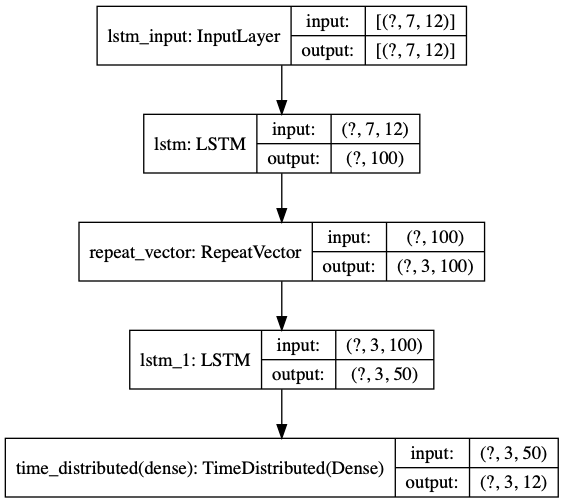

In [22]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [23]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy
    # metrics=['accuracy']
)

In [24]:
epochs_num = 500
batch_size = dataset_size

history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.2
)

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 4s 4ms/sample - loss: 2.4859 - val_loss: 2.4833
Epoch 2/500
800/800 [==============================] - 0s 136us/sample - loss: 2.4831 - val_loss: 2.4805
Epoch 3/500
800/800 [==============================] - 0s 148us/sample - loss: 2.4803 - val_loss: 2.4778
Epoch 4/500
800/800 [==============================] - 0s 182us/sample - loss: 2.4774 - val_loss: 2.4749
Epoch 5/500
800/800 [==============================] - 0s 157us/sample - loss: 2.4745 - val_loss: 2.4719
Epoch 6/500
800/800 [==============================] - 0s 149us/sample - loss: 2.4714 - val_loss: 2.4686
Epoch 7/500
800/800 [==============================] - 0s 160us/sample - loss: 2.4681 - val_loss: 2.4651
Epoch 8/500
800/800 [==============================] - 0s 155us/sample - loss: 2.4645 - val_loss: 2.4611
Epoch 9/500
800/800 [==============================] - 0s 149us/sample - loss: 2.4605 - val_loss: 2.4567
Epoch 10/50

Epoch 78/500
800/800 [==============================] - 0s 138us/sample - loss: 1.7547 - val_loss: 1.7664
Epoch 79/500
800/800 [==============================] - 0s 122us/sample - loss: 1.7513 - val_loss: 1.7618
Epoch 80/500
800/800 [==============================] - 0s 126us/sample - loss: 1.7479 - val_loss: 1.7615
Epoch 81/500
800/800 [==============================] - 0s 120us/sample - loss: 1.7446 - val_loss: 1.7546
Epoch 82/500
800/800 [==============================] - 0s 131us/sample - loss: 1.7414 - val_loss: 1.7552
Epoch 83/500
800/800 [==============================] - 0s 117us/sample - loss: 1.7376 - val_loss: 1.7481
Epoch 84/500
800/800 [==============================] - 0s 130us/sample - loss: 1.7333 - val_loss: 1.7437
Epoch 85/500
800/800 [==============================] - 0s 137us/sample - loss: 1.7297 - val_loss: 1.7442
Epoch 86/500
800/800 [==============================] - 0s 114us/sample - loss: 1.7265 - val_loss: 1.7351
Epoch 87/500
800/800 [========================

Epoch 155/500
800/800 [==============================] - 0s 129us/sample - loss: 1.6392 - val_loss: 1.6459
Epoch 156/500
800/800 [==============================] - 0s 120us/sample - loss: 1.6388 - val_loss: 1.6532
Epoch 157/500
800/800 [==============================] - 0s 122us/sample - loss: 1.6382 - val_loss: 1.6451
Epoch 158/500
800/800 [==============================] - 0s 130us/sample - loss: 1.6373 - val_loss: 1.6503
Epoch 159/500
800/800 [==============================] - 0s 115us/sample - loss: 1.6362 - val_loss: 1.6457
Epoch 160/500
800/800 [==============================] - 0s 124us/sample - loss: 1.6351 - val_loss: 1.6462
Epoch 161/500
800/800 [==============================] - 0s 125us/sample - loss: 1.6344 - val_loss: 1.6476
Epoch 162/500
800/800 [==============================] - 0s 126us/sample - loss: 1.6338 - val_loss: 1.6435
Epoch 163/500
800/800 [==============================] - 0s 115us/sample - loss: 1.6335 - val_loss: 1.6491
Epoch 164/500
800/800 [==============

Epoch 232/500
800/800 [==============================] - 0s 113us/sample - loss: 1.5742 - val_loss: 1.6023
Epoch 233/500
800/800 [==============================] - 0s 128us/sample - loss: 1.5713 - val_loss: 1.5947
Epoch 234/500
800/800 [==============================] - 0s 123us/sample - loss: 1.5689 - val_loss: 1.5942
Epoch 235/500
800/800 [==============================] - 0s 114us/sample - loss: 1.5673 - val_loss: 1.5967
Epoch 236/500
800/800 [==============================] - 0s 132us/sample - loss: 1.5665 - val_loss: 1.5903
Epoch 237/500
800/800 [==============================] - 0s 132us/sample - loss: 1.5663 - val_loss: 1.5994
Epoch 238/500
800/800 [==============================] - 0s 115us/sample - loss: 1.5660 - val_loss: 1.5885
Epoch 239/500
800/800 [==============================] - 0s 125us/sample - loss: 1.5658 - val_loss: 1.5990
Epoch 240/500
800/800 [==============================] - 0s 125us/sample - loss: 1.5642 - val_loss: 1.5859
Epoch 241/500
800/800 [==============

Epoch 309/500
800/800 [==============================] - 0s 267us/sample - loss: 1.4239 - val_loss: 1.4644
Epoch 310/500
800/800 [==============================] - 0s 171us/sample - loss: 1.4161 - val_loss: 1.4567
Epoch 311/500
800/800 [==============================] - 0s 183us/sample - loss: 1.4117 - val_loss: 1.4529
Epoch 312/500
800/800 [==============================] - 0s 191us/sample - loss: 1.4110 - val_loss: 1.4640
Epoch 313/500
800/800 [==============================] - 0s 213us/sample - loss: 1.4123 - val_loss: 1.4517
Epoch 314/500
800/800 [==============================] - 0s 207us/sample - loss: 1.4137 - val_loss: 1.4669
Epoch 315/500
800/800 [==============================] - 0s 192us/sample - loss: 1.4123 - val_loss: 1.4470
Epoch 316/500
800/800 [==============================] - 0s 197us/sample - loss: 1.4081 - val_loss: 1.4533
Epoch 317/500
800/800 [==============================] - 0s 181us/sample - loss: 1.4014 - val_loss: 1.4402
Epoch 318/500
800/800 [==============

Epoch 386/500
800/800 [==============================] - 0s 168us/sample - loss: 1.2634 - val_loss: 1.3168
Epoch 387/500
800/800 [==============================] - 0s 176us/sample - loss: 1.2569 - val_loss: 1.3177
Epoch 388/500
800/800 [==============================] - 0s 166us/sample - loss: 1.2517 - val_loss: 1.3142
Epoch 389/500
800/800 [==============================] - 0s 172us/sample - loss: 1.2493 - val_loss: 1.3109
Epoch 390/500
800/800 [==============================] - 0s 167us/sample - loss: 1.2493 - val_loss: 1.3196
Epoch 391/500
800/800 [==============================] - 0s 160us/sample - loss: 1.2503 - val_loss: 1.3107
Epoch 392/500
800/800 [==============================] - 0s 169us/sample - loss: 1.2519 - val_loss: 1.3242
Epoch 393/500
800/800 [==============================] - 0s 173us/sample - loss: 1.2522 - val_loss: 1.3100
Epoch 394/500
800/800 [==============================] - 0s 157us/sample - loss: 1.2520 - val_loss: 1.3213
Epoch 395/500
800/800 [==============

Epoch 463/500
800/800 [==============================] - 0s 136us/sample - loss: 1.1522 - val_loss: 1.2316
Epoch 464/500
800/800 [==============================] - 0s 121us/sample - loss: 1.1547 - val_loss: 1.2431
Epoch 465/500
800/800 [==============================] - 0s 120us/sample - loss: 1.1565 - val_loss: 1.2350
Epoch 466/500
800/800 [==============================] - 0s 155us/sample - loss: 1.1584 - val_loss: 1.2436
Epoch 467/500
800/800 [==============================] - 0s 149us/sample - loss: 1.1563 - val_loss: 1.2297
Epoch 468/500
800/800 [==============================] - 0s 158us/sample - loss: 1.1521 - val_loss: 1.2308
Epoch 469/500
800/800 [==============================] - 0s 149us/sample - loss: 1.1449 - val_loss: 1.2194
Epoch 470/500
800/800 [==============================] - 0s 129us/sample - loss: 1.1388 - val_loss: 1.2186
Epoch 471/500
800/800 [==============================] - 0s 119us/sample - loss: 1.1354 - val_loss: 1.2193
Epoch 472/500
800/800 [==============

In [25]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

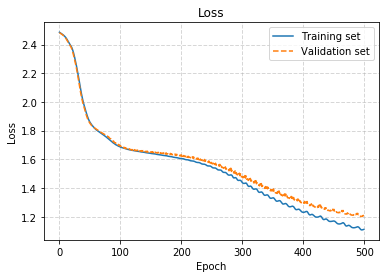

In [26]:
render_training_history(history)

In [27]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]]]

y_test:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]]]


In [28]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

predictions.shape:  (1000, 3, 12)

predictions[0]:
 [[3.6918849e-04 9.9805802e-01 4.1891087e-04 5.5550504e-04 1.6258552e-04
  8.7223096e-05 3.1881114e-05 3.3584904e-05 1.1000882e-05 4.4741817e-05
  5.7496136e-06 2.2162023e-04]
 [3.5874103e-03 1.8409967e-02 4.9067054e-02 2.7744034e-01 3.9275429e-01
  1.4572266e-01 4.5412436e-02 2.6257556e-02 2.5487967e-02 1.5764365e-02
  6.6185603e-05 2.9824931e-05]
 [8.4620252e-02 6.4329751e-02 1.2669358e-01 2.2990225e-01 1.5982306e-01
  7.5373426e-02 5.8602896e-02 5.6519736e-02 5.7561174e-02 8.6434051e-02
  5.3479620e-05 8.6398242e-05]]

predictions[1]:
 [[6.37901190e-04 4.99645770e-01 1.04871858e-03 1.10858807e-03
  8.08437064e-04 3.68242298e-04 1.73474516e-04 1.45539831e-04
  1.39203650e-04 1.20788813e-04 9.34019408e-05 4.95709985e-01]
 [3.80127788e-01 2.03536768e-02 3.96450842e-03 6.74991054e-04
  7.15380709e-04 9.93681489e-04 1.83187146e-03 1.30025009e-02
  4.20212485e-02 5.36250174e-01 2.33340743e-05 4.08011256e-05]
 [6.32084906e-02 5.83072305e-0

In [29]:
x_encoded = [decode(example, vocabulary) for example in x]
y_expected = [decode(label, vocabulary) for label in y]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 30
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

  28+12 =  40 [predict: 143] 
  54+39 =  93 [predict: 197] 
   1+15 =  16 [predict: 149] 
    2+3 =   5 [predict: 101] 
  99+21 = 120 [predict:  92] 
  20+44 =  64 [predict: 133] 
  45+57 = 102 [predict: 179] 
  83+62 = 145 [predict: 119] 
  24+20 =  44 [predict: 143] 
  91+43 = 134 [predict: 143] 
  83+28 = 111 [predict:  92] 
   45+7 =  52 [predict:  40] 
  74+93 = 167 [predict:  92] 
  67+56 = 123 [predict:  42] 
  66+25 =  91 [predict: 133] 
  32+83 = 115 [predict:  31] 
   3+77 =  80 [predict:  82] 
  74+74 = 148 [predict:  73] 
  19+22 =  41 [predict: 143] 
  40+67 = 107 [predict:  62] 
  41+22 =  63 [predict: 108] 
  21+83 = 104 [predict:  98] 
  16+45 =  61 [predict: 129] 
  99+92 = 191 [predict: 109] 
  62+18 =  80 [predict: 133] 
   62+6 =  68 [predict:  87] 
  35+18 =  53 [predict:  92] 
  38+91 = 129 [predict: 119] 
  19+38 =  57 [predict: 129] 
  96+77 = 173 [predict:  96] 
